In [2]:
!pip install lightgbm pandas numpy scikit-learn matplotlib seaborn kagglehub[pandas-datasets]

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# 1.1 Загрузка данных
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ML/all_auto_ru_09_09_2020.csv')

# 1.2 Первичный осмотр данных
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
print(df.head())

print("\nИнформация о данных:")
print(df.info())

print("\nСтатистика числовых признаков:")
print(df.describe())

# 1.3 Проверка пропущенных значений
print("\nПропущенные значения:")
print(df.isnull().sum())

Размер датасета: (89378, 26)

Первые 5 строк:
          bodyType brand   color fuelType  modelDate                   name  \
0            Седан  AUDI  040001   бензин     1990.0  2.8 MT (174 л.с.) 4WD   
1            Седан  AUDI  EE1D19   бензин     1982.0       1.8 MT (90 л.с.)   
2  Универсал 5 дв.  AUDI  0000CC   бензин     1988.0  2.3 MT (136 л.с.) 4WD   
3            Седан  AUDI  CACECB   бензин     1988.0       1.8 MT (90 л.с.)   
4            Седан  AUDI  040001   бензин     1990.0      2.0 MT (101 л.с.)   

   numberOfDoors  productionDate          vehicleConfiguration  \
0            4.0            1991          SEDAN MECHANICAL 2.8   
1            4.0            1986          SEDAN MECHANICAL 1.8   
2            5.0            1989  WAGON_5_DOORS MECHANICAL 2.3   
3            4.0            1989          SEDAN MECHANICAL 1.8   
4            4.0            1991          SEDAN MECHANICAL 2.0   

  vehicleTransmission  ...  Руль  Состояние Владельцы        ПТС Таможня  \
0     

In [6]:
import pandas as pd
import numpy as np
import json
import itertools

# Создаем словарь для хранения уникальных значений
unique_values = {}

print("🔍 Извлекаем уникальные значения из датасета...")
print("=" * 60)

# 1. КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ (автодополнение)
print("\n📌 КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ДЛЯ АВТОДОПОЛНЕНИЯ:")

# Марки автомобилей
if 'brand' in df.columns:
    brands = sorted(df['brand'].dropna().astype(str).unique())
    unique_values['brand'] = [b.strip() for b in brands if b.strip()]
    print(f"✅ Марки: {len(unique_values['brand'])} уникальных значений")
    print(f"   Примеры: {unique_values['brand'][:10]}")

# Типы кузова
if 'bodyType' in df.columns:
    body_types = sorted(df['bodyType'].dropna().astype(str).unique())
    unique_values['bodyType'] = [bt.strip() for bt in body_types if bt.strip()]
    print(f"\n✅ Типы кузова: {len(unique_values['bodyType'])} уникальных значений")
    print(f"   Примеры: {unique_values['bodyType'][:10]}")

# Цвета (извлекаем реальные названия цветов)
if 'color' in df.columns:
    colors = sorted(df['color'].dropna().astype(str).unique())
    # Фильтруем шестнадцатеричные коды (например, 040001, EE1D19)
    real_colors = [c for c in colors if not c.replace(' ', '').isalnum() or len(c) > 7]
    unique_values['color'] = [c.strip() for c in real_colors[:50] if c.strip()]
    print(f"\n✅ Цвета: {len(unique_values['color'])} уникальных значений")
    print(f"   Примеры: {unique_values['color'][:10]}")

# Тип топлива
if 'fuelType' in df.columns:
    fuel_types = sorted(df['fuelType'].dropna().astype(str).unique())
    unique_values['fuelType'] = [ft.strip() for ft in fuel_types if ft.strip()]
    print(f"\n✅ Тип топлива: {len(unique_values['fuelType'])} уникальных значений")
    print(f"   Примеры: {unique_values['fuelType']}")

# Коробка передач
if 'vehicleTransmission' in df.columns:
    transmissions = sorted(df['vehicleTransmission'].dropna().astype(str).unique())
    unique_values['vehicleTransmission'] = [t.strip() for t in transmissions if t.strip()]
    print(f"\n✅ Коробка передач: {len(unique_values['vehicleTransmission'])} уникальных значений")
    print(f"   Примеры: {unique_values['vehicleTransmission']}")

# Привод
if 'Привод' in df.columns:
    drives = sorted(df['Привод'].dropna().astype(str).unique())
    unique_values['Привод'] = [d.strip() for d in drives if d.strip()]
    print(f"\n✅ Привод: {len(unique_values['Привод'])} уникальных значений")
    print(f"   Примеры: {unique_values['Привод']}")

# ПТС
if 'ПТС' in df.columns:
    pts = sorted(df['ПТС'].dropna().astype(str).unique())
    unique_values['ПТС'] = [p.strip() for p in pts if p.strip()]
    print(f"\n✅ ПТС: {len(unique_values['ПТС'])} уникальных значений")
    print(f"   Примеры: {unique_values['ПТС']}")

# Руль
if 'Руль' in df.columns:
    wheel = sorted(df['Руль'].dropna().astype(str).unique())
    unique_values['Руль'] = [w.strip() for w in wheel if w.strip()]
    print(f"\n✅ Руль: {len(unique_values['Руль'])} уникальных значений")
    print(f"   Примеры: {unique_values['Руль']}")

# 2. МОДЕЛИ АВТОМОБИЛЕЙ (с группировкой по маркам)
print("\n" + "=" * 60)
print("🚗 МОДЕЛИ АВТОМОБИЛЕЙ ПО МАРКАМ:")

if 'brand' in df.columns and 'model' in df.columns:
    # Создаем словарь бренд -> список моделей
    brand_models = {}

    # Группируем модели по брендам
    for brand in df['brand'].dropna().unique():
        brand = str(brand).strip()
        models = df[df['brand'] == brand]['model'].dropna().astype(str).unique()
        models = sorted([m.strip() for m in models if m.strip()])
        if models:
            brand_models[brand] = models[:50]  # Ограничиваем 50 моделями на бренд
            print(f"   {brand}: {len(models)} моделей")

    unique_values['brand_models'] = brand_models

# 3. ГОДЫ ВЫПУСКА (диапазон)
print("\n" + "=" * 60)
print("📅 ЧИСЛОВЫЕ ПАРАМЕТРЫ (ДИАПАЗОНЫ):")

if 'productionDate' in df.columns:
    year_min = int(df['productionDate'].min())
    year_max = int(df['productionDate'].max())
    unique_values['productionDate_range'] = {
        'min': year_min,
        'max': year_max,
        'values': list(range(year_min, year_max + 1))
    }
    print(f"✅ Год выпуска: от {year_min} до {year_max}")

if 'modelDate' in df.columns:
    model_year_min = int(df['modelDate'].min())
    model_year_max = int(df['modelDate'].max())
    unique_values['modelDate_range'] = {
        'min': model_year_min,
        'max': model_year_max,
        'values': list(range(model_year_min, model_year_max + 1))
    }
    print(f"✅ Модельный год: от {model_year_min} до {model_year_max}")

# Пробег
if 'mileage' in df.columns:
    mileage_min = int(df['mileage'].min())
    mileage_max = int(df['mileage'].max())
    mileage_median = int(df['mileage'].median())
    unique_values['mileage_range'] = {
        'min': mileage_min,
        'max': mileage_max,
        'median': mileage_median,
        'step': 1000
    }
    print(f"✅ Пробег: от {mileage_min:,} до {mileage_max:,} км")

# Мощность двигателя
if 'enginePower' in df.columns:
    power_min = int(df['enginePower'].min())
    power_max = int(df['enginePower'].max())
    power_median = int(df['enginePower'].median())
    unique_values['enginePower_range'] = {
        'min': power_min,
        'max': power_max,
        'median': power_median,
        'step': 10
    }
    print(f"✅ Мощность: от {power_min} до {power_max} л.с.")

# Объем двигателя (нужно преобразовать из строки)
if 'engineDisplacement' in df.columns:
    # Пробуем извлечь числовое значение
    try:
        # Если это строки типа "2.8 LTR"
        df['engineDisplacement_num'] = df['engineDisplacement'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
        volume_min = float(df['engineDisplacement_num'].min())
        volume_max = float(df['engineDisplacement_num'].max())
        volume_median = float(df['engineDisplacement_num'].median())

        unique_values['engineDisplacement_range'] = {
            'min': volume_min,
            'max': volume_max,
            'median': volume_median,
            'step': 0.1
        }
        print(f"✅ Объем двигателя: от {volume_min} до {volume_max} л")
    except:
        print("⚠️ Не удалось извлечь объем двигателя")

# Количество дверей
if 'numberOfDoors' in df.columns:
    doors = sorted(df['numberOfDoors'].dropna().unique())
    unique_values['numberOfDoors'] = [int(d) for d in doors if pd.notna(d)]
    print(f"✅ Количество дверей: {unique_values['numberOfDoors']}")

# Количество владельцев
if 'Владельцы' in df.columns:
    owners = sorted(df['Владельцы'].dropna().unique())
    unique_values['Владельцы'] = [int(o) for o in owners if pd.notna(o)]
    print(f"✅ Владельцы: {unique_values['Владельцы']}")

# 4. ДОПОЛНИТЕЛЬНО: СОЗДАЕМ ПРЕДЛОЖЕНИЯ ДЛЯ ПОЛЯ "name"
print("\n" + "=" * 60)
print("🏷️ ПРЕДЛОЖЕНИЯ ДЛЯ НАЗВАНИЯ МОДЕЛИ (name):")

if 'name' in df.columns:
    # Берем наиболее частые названия
    top_names = df['name'].value_counts().head(100).index.tolist()
    unique_values['name_suggestions'] = [str(n).strip() for n in top_names if pd.notna(n)]
    print(f"✅ Собрано {len(unique_values['name_suggestions'])} популярных названий")

# 5. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
print("\n" + "=" * 60)
print("💾 СОХРАНЯЕМ ДАННЫЕ...")

# Сохраняем в JSON
with open('car_parameters.json', 'w', encoding='utf-8') as f:
    json.dump(unique_values, f, ensure_ascii=False, indent=2, default=str)

print("✅ Данные сохранены в 'car_parameters.json'")

# Также создаем CSV с уникальными значениями для удобства
summary_data = []
for key, value in unique_values.items():
    if isinstance(value, list):
        summary_data.append({
            'parameter': key,
            'type': 'list',
            'count': len(value),
            'examples': ', '.join([str(v) for v in value[:3]])
        })
    elif isinstance(value, dict) and 'min' in value:
        summary_data.append({
            'parameter': key,
            'type': 'range',
            'min': value.get('min'),
            'max': value.get('max'),
            'median': value.get('median', 'N/A')
        })

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('parameters_summary.csv', index=False, encoding='utf-8-sig')
print("✅ Сводка сохранена в 'parameters_summary.csv'")

# 6. ВЫВОД СВОДНОЙ ИНФОРМАЦИИ
print("\n" + "=" * 60)
print("📊 СВОДНАЯ ИНФОРМАЦИЯ:")
print(f"Всего параметров: {len(unique_values)}")
print(f"Количество марок: {len(unique_values.get('brand', []))}")
print(f"Количество типов кузова: {len(unique_values.get('bodyType', []))}")
print(f"Количество коробок передач: {len(unique_values.get('vehicleTransmission', []))}")

# Создаем HTML файл для просмотра данных
html_content = """
<!DOCTYPE html>
<html>
<head>
    <meta charset="UTF-8">
    <title>Авто параметры</title>
    <style>
        body { font-family: Arial, sans-serif; margin: 40px; }
        .parameter { margin: 20px 0; padding: 15px; border: 1px solid #ddd; border-radius: 5px; }
        .param-name { font-weight: bold; color: #333; }
        .values { margin: 10px 0; color: #666; }
        .count { color: #007bff; font-weight: bold; }
    </style>
</head>
<body>
    <h1>🚗 Параметры автомобилей из датасета</h1>
"""

for key, value in unique_values.items():
    if isinstance(value, list):
        html_content += f"""
        <div class="parameter">
            <div class="param-name">{key}: <span class="count">{len(value)} значений</span></div>
            <div class="values">{', '.join([str(v) for v in value[:10]])}...</div>
        </div>
        """
    elif isinstance(value, dict) and 'min' in value:
        html_content += f"""
        <div class="parameter">
            <div class="param-name">{key}:</div>
            <div class="values">от {value['min']} до {value['max']} (медиана: {value.get('median', 'N/A')})</div>
        </div>
        """

html_content += """
</body>
</html>
"""

with open('car_parameters_preview.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print("✅ HTML превью создано: 'car_parameters_preview.html'")
print("\n🎯 Готово! Теперь можно создавать интерфейс с автодополнением.")

🔍 Извлекаем уникальные значения из датасета...

📌 КАТЕГОРИАЛЬНЫЕ ПРИЗНАКИ ДЛЯ АВТОДОПОЛНЕНИЯ:
✅ Марки: 36 уникальных значений
   Примеры: ['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO', 'DODGE', 'FORD']

✅ Типы кузова: 168 уникальных значений
   Примеры: ['Внедорожник 3 дв.', 'Внедорожник 3 дв. 78', 'Внедорожник 3 дв. 90', 'Внедорожник 5 дв.', 'Внедорожник 5 дв. 110', 'Внедорожник 5 дв. 4x4', 'Внедорожник 5 дв. 76', 'Внедорожник 5 дв. Allspace', 'Внедорожник 5 дв. Arctic Trucks', 'Внедорожник 5 дв. Cooper S']

✅ Цвета: 0 уникальных значений
   Примеры: []

✅ Тип топлива: 6 уникальных значений
   Примеры: ['бензин', 'газ', 'гибрид', 'дизель', 'универсал', 'электро']

✅ Коробка передач: 4 уникальных значений
   Примеры: ['AUTOMATIC', 'MECHANICAL', 'ROBOT', 'VARIATOR']

✅ Привод: 3 уникальных значений
   Примеры: ['задний', 'передний', 'полный']

✅ ПТС: 2 уникальных значений
   Примеры: ['DUPLICATE', 'ORIGINAL']

✅ Руль: 2 уникальных значений
   Примеры:

НАЧИНАЕМ ОБРАБОТКУ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ...
1. УДАЛЕНИЕ ПОЛНОСТЬЮ ПУСТЫХ СТОЛБЦОВ:
Удалены столбцы: ['Состояние', 'hidden']

2. ОБРАБОТКА ЧИСЛОВЫХ ПРИЗНАКОВ:
  modelDate: 1 -> 0 пропусков
  numberOfDoors: 1 -> 0 пропусков
  enginePower: 1 -> 0 пропусков
  Владельцы: 13588 -> 0 пропусков
  price: 410 -> 0 пропусков
  engineDisplacement_num: 3362 -> 0 пропусков

3. ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:
  bodyType: 1 -> 0 пропусков
  name: 1 -> 0 пропусков
  vehicleConfiguration: 1 -> 0 пропусков
  vehicleTransmission: 1 -> 0 пропусков
  engineDisplacement: 1 -> 0 пропусков
  description: 3234 -> 0 пропусков
  Привод: 1 -> 0 пропусков
  ПТС: 361 -> 0 пропусков
  Владение: 59923 -> 0 пропусков

4. УДАЛЕНИЕ СТРОК С ПРОПУСКАМИ В КЛЮЧЕВЫХ ПРИЗНАКАХ:
Всего удалено строк: 0

5. ФИНАЛЬНАЯ ПРОВЕРКА:
Общее количество пропусков: 0
✅ Все пропуски успешно обработаны!

Финальный размер датасета: (88968, 25)

ПОДГОТОВКА ДАННЫХ ДЛЯ LIGHTGBM...

1. ОБРАБОТКА ТЕКСТОВЫХ ПОЛЕЙ:
  Преобразовано поле 'descriptio

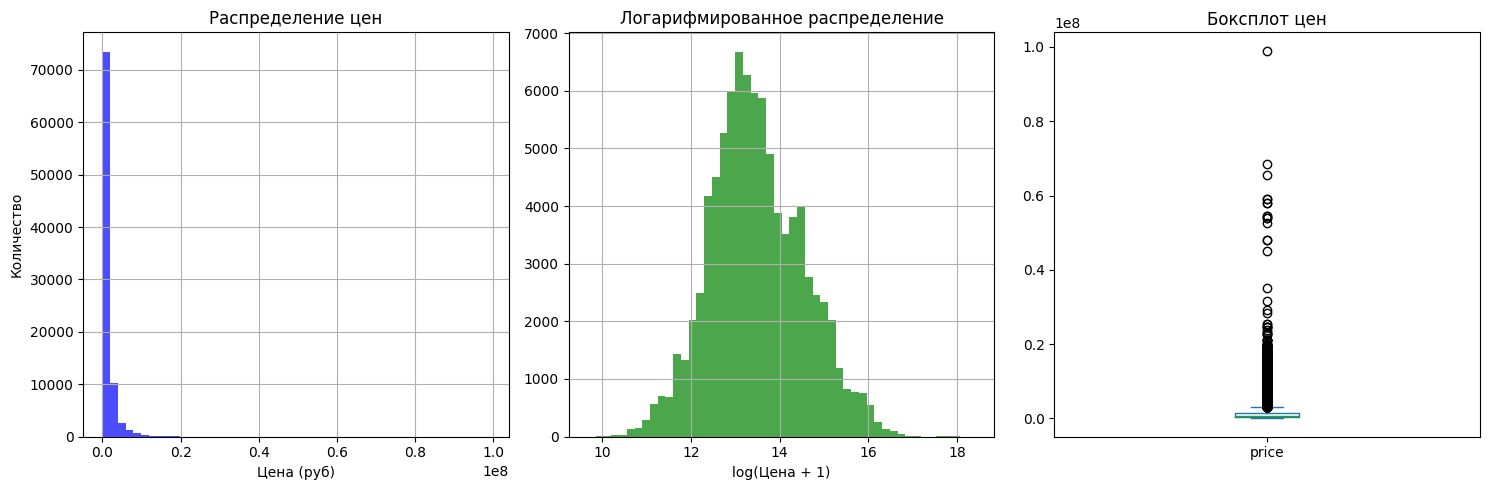


7. РАЗДЕЛЕНИЕ ДАННЫХ:
Признаки (X): (88968, 25)
Целевая переменная (y): (88968,)

Разделение данных:
  Обучающая выборка: (71174, 25)
  Тестовая выборка: (17794, 25)

8. СОХРАНЕНИЕ ДАННЫХ:
  Label encoders сохранены в 'label_encoders.pkl'
  Названия признаков сохранены в 'feature_names.pkl'

✅ ДАННЫЕ ПОЛНОСТЬЮ ПОДГОТОВЛЕНЫ ДЛЯ LIGHTGBM!
Итоговый размер: (88968, 26)
Количество признаков: 25
Количество обучающих примеров: 71174
Количество тестовых примеров: 17794


In [7]:
# ДЕТАЛЬНАЯ ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
print("НАЧИНАЕМ ОБРАБОТКУ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ...")
print("=" * 60)

# 1. Сначала удалим полностью пустые столбцы
print("1. УДАЛЕНИЕ ПОЛНОСТЬЮ ПУСТЫХ СТОЛБЦОВ:")
empty_columns = ['Состояние', 'hidden']  # 100% пропусков
df = df.drop(columns=empty_columns)
print(f"Удалены столбцы: {empty_columns}")

# 2. Обработка числовых признаков
print("\n2. ОБРАБОТКА ЧИСЛОВЫХ ПРИЗНАКОВ:")
numeric_columns = df.select_dtypes(include=[np.number]).columns

for col in numeric_columns:
    if df[col].isnull().any():
        before = df[col].isnull().sum()
        if col == 'price':  # Целевая переменная - удаляем строки с пропусками
            df = df.dropna(subset=[col])
        else:
            # Заполняем медианой для числовых признаков
            df[col] = df[col].fillna(df[col].median())
        after = df[col].isnull().sum()
        print(f"  {col}: {before} -> {after} пропусков")

# 3. Обработка категориальных признаков
print("\n3. ОБРАБОТКА КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    if df[col].isnull().any():
        before = df[col].isnull().sum()

        if col == 'description':  # Описание - заполняем пустой строкой
            df[col] = df[col].fillna('')
        elif col == 'Владение':  # Сложный признак - создаем отдельную категорию
            df[col] = df[col].fillna('Не указано')
        else:
            # Для остальных категориальных - заполняем модой
            if not df[col].mode().empty:
                mode_value = df[col].mode()[0]
                df[col] = df[col].fillna(mode_value)
            else:
                df[col] = df[col].fillna('Неизвестно')

        after = df[col].isnull().sum()
        print(f"  {col}: {before} -> {after} пропусков")

# 4. Удаляем строки с пропусками в ключевых признаках
print("\n4. УДАЛЕНИЕ СТРОК С ПРОПУСКАМИ В КЛЮЧЕВЫХ ПРИЗНАКАХ:")
key_columns_to_check = ['bodyType', 'modelDate', 'name', 'numberOfDoors',
                       'vehicleConfiguration', 'vehicleTransmission',
                       'engineDisplacement', 'enginePower', 'Привод']
initial_rows = len(df)

for col in key_columns_to_check:
    if col in df.columns and df[col].isnull().any():
        before = len(df)
        df = df.dropna(subset=[col])
        after = len(df)
        print(f"  {col}: удалено {before - after} строк")

print(f"Всего удалено строк: {initial_rows - len(df)}")

# 5. ФИНАЛЬНАЯ ПРОВЕРКА
print("\n5. ФИНАЛЬНАЯ ПРОВЕРКА:")
total_missing = df.isnull().sum().sum()
print(f"Общее количество пропусков: {total_missing}")

if total_missing == 0:
    print("✅ Все пропуски успешно обработаны!")
else:
    print("❌ Остались пропуски. Детальный анализ:")
    missing_cols = df.isnull().sum()
    missing_cols = missing_cols[missing_cols > 0]
    for col, count in missing_cols.items():
        print(f"  {col}: {count} пропусков")

print(f"\nФинальный размер датасета: {df.shape}")

# ПРЕДОБРАБОТКА ДАННЫХ ДЛЯ LIGHTGBM
print("\n" + "=" * 60)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ LIGHTGBM...")

# 1. Обработка текстовых полей (упрощаем)
print("\n1. ОБРАБОТКА ТЕКСТОВЫХ ПОЛЕЙ:")
if 'description' in df.columns:
    # Заменяем description на его длину (как числовой признак)
    df['description_length'] = df['description'].apply(len)
    df = df.drop(columns=['description'])
    print("  Преобразовано поле 'description' в длину текста")

# 2. Обработка engineDisplacement (извлекаем числовое значение)
print("\n2. ОБРАБОТКА ENGINE DISPLACEMENT:")
if 'engineDisplacement' in df.columns:
    # Пример: "2.0 LTR" -> 2.0
    df['engineDisplacement'] = df['engineDisplacement'].str.extract(r'(\d+\.\d+|\d+)').astype(float)
    print("  Извлечено числовое значение из engineDisplacement")

# ПРОДОЛЖАЕМ ПОДГОТОВКУ ДАННЫХ ДЛЯ LIGHTGBM
print("ПОДГОТОВКА ДАННЫХ ДЛЯ LIGHTGBM...")
print("=" * 60)

# 3. ОБРАБОТКА ДАТ (исправленная версия)
print("\n3. ОБРАБОТКА ДАТ:")
if 'start_date' in df.columns:
    try:
        # Пробуем разные форматы дат
        df['start_date'] = pd.to_datetime(df['start_date'], format='ISO8601', errors='coerce')

        # Проверяем результат
        successful_conversions = df['start_date'].notna().sum()
        print(f"  Успешно преобразовано дат: {successful_conversions}/{len(df)}")

        if successful_conversions > 0:
            df['start_year'] = df['start_date'].dt.year
            df['start_month'] = df['start_date'].dt.month
            df['start_day'] = df['start_date'].dt.day
            df = df.drop(columns=['start_date'])
            print("  Преобразовано поле 'start_date' в год, месяц и день")
        else:
            # Если не удалось преобразовать, удаляем столбец
            df = df.drop(columns=['start_date'])
            print("  Не удалось преобразовать даты, столбец удален")

    except Exception as e:
        print(f"  Ошибка при обработке дат: {e}")
        df = df.drop(columns=['start_date'])
        print("  Столбец 'start_date' удален")

# 4. Кодирование категориальных признаков
print("\n4. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

print(f"Категориальные признаки для кодирования ({len(categorical_columns)}):")
for col in categorical_columns:
    if col != 'price':  # Не кодируем целевую переменную
        unique_count = df[col].nunique()
        print(f"  {col}: {unique_count} уникальных значений")

        try:
            # Используем Label Encoding для LightGBM
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            print(f"    ✅ Успешно закодирован")
        except Exception as e:
            print(f"    ❌ Ошибка при кодировании {col}: {e}")
            # Если не удалось закодировать, удаляем столбец
            df = df.drop(columns=[col])
            print(f"    Столбец {col} удален")

print("✅ Категориальные признаки обработаны")

# 5. УДАЛЕНИЕ СТОЛБЦОВ, КОТОРЫЕ МЕШАЮТ ОБУЧЕНИЮ
print("\n5. ОЧИСТКА ОТ МЕШАЮЩИХ СТОЛБЦОВ:")

# Удаляем столбцы, которые могут мешать или не несут полезной информации
columns_to_drop = []
for col in df.columns:
    # Удаляем столбцы с постоянным значением
    if df[col].nunique() <= 1:
        columns_to_drop.append(col)
        print(f"  Удален {col} - постоянное значение")

    # Удаляем столбцы с слишком большим количеством уникальных значений (возможно, идентификаторы)
    elif df[col].nunique() > len(df) * 0.8 and col != 'price':
        columns_to_drop.append(col)
        print(f"  Удален {col} - слишком много уникальных значений")

if columns_to_drop:
    df = df.drop(columns=columns_to_drop)

# 6. ФИНАЛЬНАЯ ПРОВЕРКА ДАННЫХ
print("\n6. ФИНАЛЬНАЯ ПРОВЕРКА ДАННЫХ:")
print(f"Размер данных: {df.shape}")
print(f"Типы данных:")
print(df.dtypes.value_counts())

# Проверяем целевую переменную
if 'price' in df.columns:
    print(f"\nЦелевая переменная 'price':")
    print(f"  Диапазон: {df['price'].min():,.0f} - {df['price'].max():,.0f} руб.")
    print(f"  Медиана: {df['price'].median():,.0f} руб.")
    print(f"  Среднее: {df['price'].mean():,.0f} руб.")
    print(f"  Количество записей: {len(df)}")

    # Визуализация распределения цены
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    df['price'].hist(bins=50, alpha=0.7, color='blue')
    plt.title('Распределение цен')
    plt.xlabel('Цена (руб)')
    plt.ylabel('Количество')

    plt.subplot(1, 3, 2)
    # Логарифмированная цена
    np.log1p(df['price']).hist(bins=50, alpha=0.7, color='green')
    plt.title('Логарифмированное распределение')
    plt.xlabel('log(Цена + 1)')

    plt.subplot(1, 3, 3)
    # Боксплот
    df['price'].plot(kind='box')
    plt.title('Боксплот цен')

    plt.tight_layout()
    plt.show()

# 7. РАЗДЕЛЕНИЕ ДАННЫХ НА ПРИЗНАКИ И ЦЕЛЕВУЮ ПЕРЕМЕННУЮ
print("\n7. РАЗДЕЛЕНИЕ ДАННЫХ:")
X = df.drop('price', axis=1)
y = df['price']

print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")

# 8. РАЗДЕЛЕНИЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nРазделение данных:")
print(f"  Обучающая выборка: {X_train.shape}")
print(f"  Тестовая выборка: {X_test.shape}")

# 9. СОХРАНЕНИЕ ПОДГОТОВЛЕННЫХ ДАННЫХ
print("\n8. СОХРАНЕНИЕ ДАННЫХ:")
# Сохраняем кодировщики для будущего использования
import pickle

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("  Label encoders сохранены в 'label_encoders.pkl'")

# Сохраняем названия признаков
feature_names = X.columns.tolist()
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)
print("  Названия признаков сохранены в 'feature_names.pkl'")

print("\n" + "=" * 60)
print("✅ ДАННЫЕ ПОЛНОСТЬЮ ПОДГОТОВЛЕНЫ ДЛЯ LIGHTGBM!")
print(f"Итоговый размер: {df.shape}")
print(f"Количество признаков: {X.shape[1]}")
print(f"Количество обучающих примеров: {X_train.shape[0]}")
print(f"Количество тестовых примеров: {X_test.shape[0]}")

НАЧИНАЕМ ОБУЧЕНИЕ LIGHTGBM МОДЕЛИ...
1. НАСТРОЙКА ПАРАМЕТРОВ LIGHTGBM:
Параметры модели установлены:
  objective: regression
  metric: mae
  boosting_type: gbdt
  num_leaves: 31
  learning_rate: 0.05
  feature_fraction: 0.9
  bagging_fraction: 0.8
  bagging_freq: 5
  verbose: -1
  max_depth: -1
  min_data_in_leaf: 20
  lambda_l1: 0.1
  lambda_l2: 0.1
  random_state: 42
  n_jobs: -1

2. СОЗДАНИЕ DATASET ОБЪЕКТОВ:
✅ Dataset объекты созданы

3. ЗАПУСК ОБУЧЕНИЯ МОДЕЛИ...
Начинаем обучение на 1000 итераций...
(Обучение может занять несколько минут)
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 179032	test's l1: 183447
[200]	train's l1: 154370	test's l1: 162733
[300]	train's l1: 142551	test's l1: 153699
[400]	train's l1: 134874	test's l1: 148622
[500]	train's l1: 129251	test's l1: 144701
[600]	train's l1: 124513	test's l1: 141742
[700]	train's l1: 120663	test's l1: 139706
[800]	train's l1: 117191	test's l1: 138166
[900]	train's l1: 114235	test's l1: 136769
[1

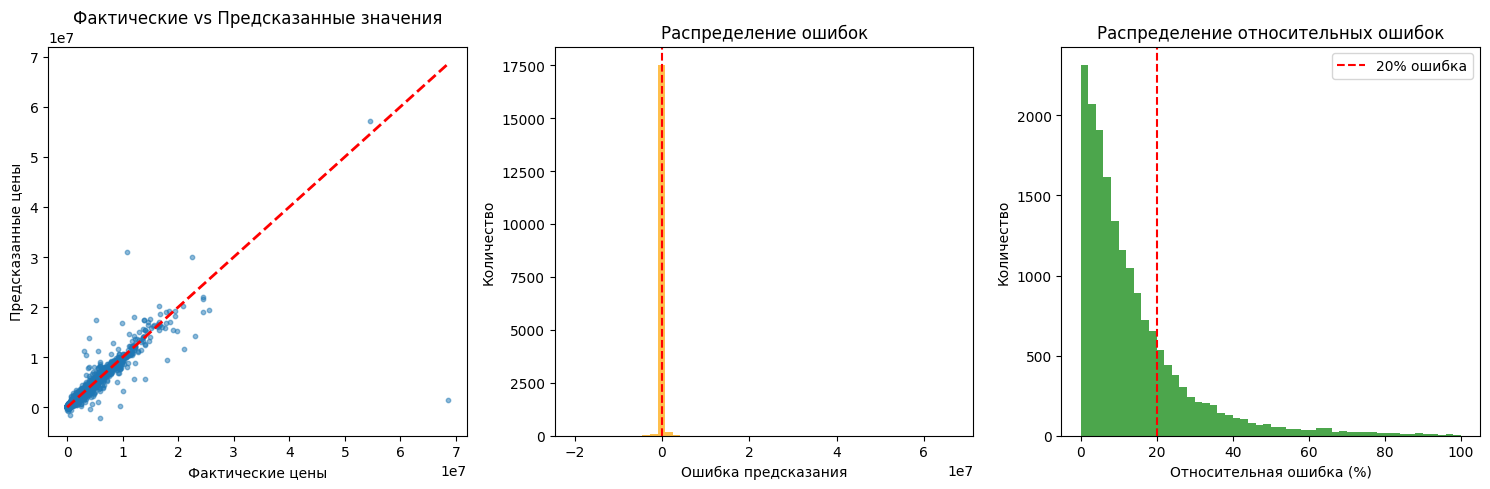


6. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ:
Топ-15 самых важных признаков:
12. enginePower               748803387294121984.00
13. mileage                   611403236036542464.00
 8. productionDate            283272121484935168.00
 6. name                      134245428404633600.00
11. engineDisplacement        86967378242027520.00
20. model                     78394503119634432.00
 5. modelDate                 77247476610285568.00
 2. brand                     45293313816756224.00
 9. vehicleConfiguration      44757879047864320.00
15. Привод                    34012490988322816.00
 4. fuelType                  29503807418957824.00
14. Комплектация              27356267590680576.00
22. description_length        19629176522981376.00
25. start_day                 15320964810522624.00
 1. bodyType                  12432694339698688.00


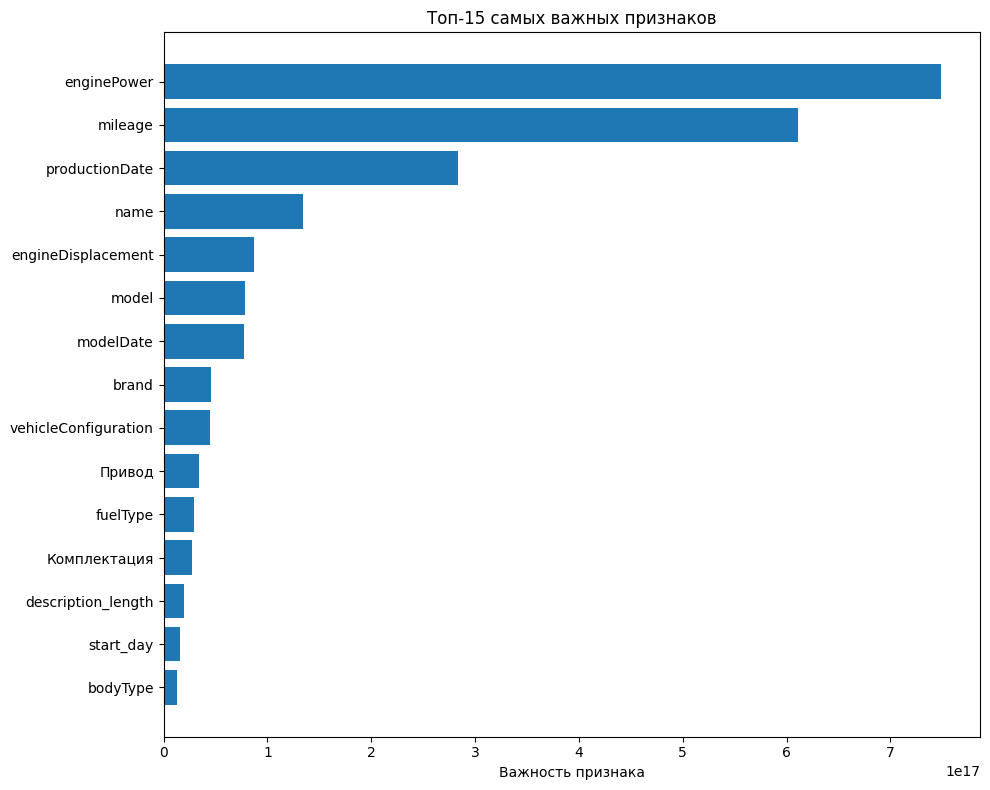


7. СОХРАНЕНИЕ МОДЕЛИ И РЕЗУЛЬТАТОВ:
✅ Модель сохранена как 'lightgbm_car_price_model.txt'
✅ Результаты сохранены в 'model_results.pkl'

8. СОЗДАНИЕ ФУНКЦИИ ДЛЯ ПРЕДСКАЗАНИЙ:
✅ Функция для предсказаний создана

9. ТЕСТИРОВАНИЕ ФУНКЦИИ ПРЕДСКАЗАНИЯ:
⚠️  Замена неизвестной категории '3.0' на 'Внедорожник 3 дв.' в столбце bodyType
⚠️  Замена неизвестной категории '21.0' на 'AUDI' в столбце brand
⚠️  Замена неизвестной категории '2.0' на '0000CC' в столбце color
⚠️  Замена неизвестной категории '3.0' на 'бензин' в столбце fuelType
⚠️  Замена неизвестной категории '2872.0' на '+ 1.4 AT (75 л.с.)' в столбце name
⚠️  Замена неизвестной категории '117.0' на 'ALLROAD_3_DOORS AUTOMATIC 0.7' в столбце vehicleConfiguration
⚠️  Замена неизвестной категории '0.0' на 'AUTOMATIC' в столбце vehicleTransmission
⚠️  Замена неизвестной категории '3101.0' на '{'id': '0', 'name': ''}' в столбце Комплектация
⚠️  Замена неизвестной категории '2.0' на 'задний' в столбце Привод
⚠️  Замена неизвестной категории 

In [8]:
# ОБУЧЕНИЕ LIGHTGBM МОДЕЛИ
print("НАЧИНАЕМ ОБУЧЕНИЕ LIGHTGBM МОДЕЛИ...")
print("=" * 60)

# 1. БАЗОВЫЕ ПАРАМЕТРЫ МОДЕЛИ
print("1. НАСТРОЙКА ПАРАМЕТРОВ LIGHTGBM:")

params = {
    'objective': 'regression',           # Задача регрессии
    'metric': 'mae',                     # Основная метрика - средняя абсолютная ошибка
    'boosting_type': 'gbdt',             # Алгоритм градиентного бустинга
    'num_leaves': 31,                    # Максимальное количество листьев
    'learning_rate': 0.05,               # Скорость обучения
    'feature_fraction': 0.9,             # Доля признаков для каждого дерева
    'bagging_fraction': 0.8,             # Доля данных для каждого дерева
    'bagging_freq': 5,                   # Частота бэггинга
    'verbose': -1,                       # Минимальный вывод
    'max_depth': -1,                     # Без ограничения глубины
    'min_data_in_leaf': 20,              # Минимальное количество данных в листе
    'lambda_l1': 0.1,                    # L1 регуляризация
    'lambda_l2': 0.1,                    # L2 регуляризация
    'random_state': 42,                  # Для воспроизводимости
    'n_jobs': -1,                        # Использовать все ядра процессора
}

print("Параметры модели установлены:")
for key, value in params.items():
    print(f"  {key}: {value}")

# 2. СОЗДАНИЕ DATASET ОБЪЕКТОВ
print("\n2. СОЗДАНИЕ DATASET ОБЪЕКТОВ:")

# Создаем Dataset объекты для более эффективного обучения
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

print("✅ Dataset объекты созданы")

# 3. ОБУЧЕНИЕ МОДЕЛИ
print("\n3. ЗАПУСК ОБУЧЕНИЯ МОДЕЛИ...")

# Количество деревьев (итераций бустинга)
num_round = 1000

print(f"Начинаем обучение на {num_round} итераций...")
print("(Обучение может занять несколько минут)")

# Обучение модели с ранней остановкой
model = lgb.train(
    params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]
)

print("✅ Обучение завершено!")
print(f"Лучшая итерация: {model.best_iteration}")

# 4. ПРЕДСКАЗАНИЯ И ОЦЕНКА МОДЕЛИ
print("\n4. ОЦЕНКА КАЧЕСТВА МОДЕЛИ:")

# Предсказания на тестовой выборке
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Вычисление метрик
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Дополнительные метрики
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
within_10_percent = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.10) * 100
within_15_percent = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.15) * 100
within_20_percent = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.20) * 100

print("\n📊 РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print("=" * 40)
print(f"MAE (Средняя абсолютная ошибка): {mae:,.0f} руб.")
print(f"RMSE (Средняя квадратичная ошибка): {rmse:,.0f} руб.")
print(f"R² (Коэффициент детерминации): {r2:.3f}")
print(f"MAPE (Средняя абсолютная процентная ошибка): {mape:.1f}%")
print(f"\nТочность в пределах 10%: {within_10_percent:.1f}%")
print(f"Точность в пределах 15%: {within_15_percent:.1f}%")
print(f"Точность в пределах 20%: {within_20_percent:.1f}%")

# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
print("\n5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ:")

plt.figure(figsize=(15, 5))

# График 1: Фактические vs Предсказанные значения
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Фактические цены')
plt.ylabel('Предсказанные цены')
plt.title('Фактические vs Предсказанные значения')

# График 2: Распределение ошибок
plt.subplot(1, 3, 2)
errors = y_test - y_pred
plt.hist(errors, bins=50, alpha=0.7, color='orange')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Ошибка предсказания')
plt.ylabel('Количество')
plt.title('Распределение ошибок')

# График 3: Относительные ошибки
plt.subplot(1, 3, 3)
relative_errors = np.abs((y_test - y_pred) / y_test) * 100
plt.hist(relative_errors, bins=50, alpha=0.7, color='green', range=(0, 100))
plt.axvline(x=20, color='red', linestyle='--', label='20% ошибка')
plt.xlabel('Относительная ошибка (%)')
plt.ylabel('Количество')
plt.title('Распределение относительных ошибок')
plt.legend()

plt.tight_layout()
plt.show()

# 6. ВАЖНОСТЬ ПРИЗНАКОВ
print("\n6. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ:")

# Получаем важность признаков
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print("Топ-15 самых важных признаков:")
print("=" * 40)
for i, row in feature_importance.head(15).iterrows():
    print(f"{i+1:2d}. {row['feature']:25} {row['importance']:10.2f}")

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)

plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Важность признака')
plt.title('Топ-15 самых важных признаков')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 7. СОХРАНЕНИЕ МОДЕЛИ
print("\n7. СОХРАНЕНИЕ МОДЕЛИ И РЕЗУЛЬТАТОВ:")

# Сохраняем модель
model.save_model('lightgbm_car_price_model.txt')
print("✅ Модель сохранена как 'lightgbm_car_price_model.txt'")

# Сохраняем результаты в файл
results = {
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'mape': mape,
    'within_10_percent': within_10_percent,
    'within_15_percent': within_15_percent,
    'within_20_percent': within_20_percent,
    'best_iteration': model.best_iteration
}

with open('model_results.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✅ Результаты сохранены в 'model_results.pkl'")

# 8. ФУНКЦИЯ ДЛЯ ПРЕДСКАЗАНИЙ НА НОВЫХ ДАННЫХ
print("\n8. СОЗДАНИЕ ФУНКЦИИ ДЛЯ ПРЕДСКАЗАНИЙ:")

def predict_car_price(car_features):
    """
    Предсказывает цену автомобиля на основе характеристик

    Parameters:
    car_features (dict): Словарь с характеристиками автомобиля

    Returns:
    float: Предсказанная цена
    """
    try:
        # Загрузка модели
        loaded_model = lgb.Booster(model_file='lightgbm_car_price_model.txt')

        # Загрузка label encoders
        with open('label_encoders.pkl', 'rb') as f:
            loaded_encoders = pickle.load(f)

        # Загрузка названий признаков
        with open('feature_names.pkl', 'rb') as f:
            feature_names = pickle.load(f)

        # Создаем DataFrame из входных данных
        input_df = pd.DataFrame([car_features])

        # Применяем кодирование к категориальным признакам
        for col in input_df.columns:
            if col in loaded_encoders:
                # Для неизвестных категорий используем самое частое значение
                known_categories = set(loaded_encoders[col].classes_)
                input_value = input_df[col].iloc[0]

                if input_value not in known_categories:
                    # Заменяем на самое частое значение
                    most_frequent = loaded_encoders[col].classes_[0]
                    input_df[col] = most_frequent
                    print(f"⚠️  Замена неизвестной категории '{input_value}' на '{most_frequent}' в столбце {col}")

                input_df[col] = loaded_encoders[col].transform(input_df[col])

        # Добавляем отсутствующие признаки (заполняем 0)
        for col in feature_names:
            if col not in input_df.columns:
                input_df[col] = 0

        # Упорядочиваем столбцы как при обучении
        input_df = input_df[feature_names]

        # Предсказание
        predicted_price = loaded_model.predict(input_df)[0]

        return predicted_price

    except Exception as e:
        print(f"❌ Ошибка при предсказании: {e}")
        return None

print("✅ Функция для предсказаний создана")

# 9. ТЕСТИРУЕМ ФУНКЦИЮ ПРЕДСКАЗАНИЯ
print("\n9. ТЕСТИРОВАНИЕ ФУНКЦИИ ПРЕДСКАЗАНИЯ:")

# Берем случайный пример из тестовой выборки для демонстрации
sample_idx = X_test.index[0]
sample_features = X.loc[sample_idx].to_dict()
actual_price = y.loc[sample_idx]

predicted_price = predict_car_price(sample_features)

if predicted_price is not None:
    error = abs(predicted_price - actual_price)
    error_percent = (error / actual_price) * 100

    print(f"Тестовый пример:")
    print(f"  Фактическая цена: {actual_price:,.0f} руб.")
    print(f"  Предсказанная цена: {predicted_price:,.0f} руб.")
    print(f"  Ошибка: {error:,.0f} руб. ({error_percent:.1f}%)")

print("\n" + "=" * 60)
print("🎉 LIGHTGBM МОДЕЛЬ УСПЕШНО ОБУЧЕНА И СОХРАНЕНА!")
print("=" * 60)
print("\nЧТО МЫ СДЕЛАЛИ:")
print("✅ Обучили модель LightGBM для предсказания цен на автомобили")
print("✅ Оценили качество модели на тестовой выборке")
print("✅ Проанализировали важность признаков")
print("✅ Сохранили модель и все необходимые файлы")
print("✅ Создали функцию для предсказаний на новых данных")

print(f"\n📈 КАЧЕСТВО МОДЕЛИ:")
print(f"   Средняя ошибка: {mae:,.0f} руб. ({mape:.1f}%)")
print(f"   Точность в пределах 15%: {within_15_percent:.1f}%")
print(f"   Модель объясняет {r2*100:.1f}% дисперсии цен")

print(f"\n🔧 КАК ИСПОЛЬЗОВАТЬ:")
print("   Для предсказания цены нового автомобиля используйте функцию predict_car_price()")
print("   Пример: predict_car_price({'brand': 'AUDI', 'year': 2015, 'mileage': 50000, ...})")

In [17]:
def predict_car_price(car_features):
    """
    Предсказывает цену автомобиля на основе характеристик

    Parameters:
    car_features (dict): Словарь с характеристиками автомобиля

    Returns:
    float: Предсказанная цена
    """
    try:
        # Загрузка модели
        loaded_model = lgb.Booster(model_file='lightgbm_car_price_model.txt')

        # Загрузка label encoders
        with open('label_encoders.pkl', 'rb') as f:
            loaded_encoders = pickle.load(f)

        # Загрузка названий признаков
        with open('feature_names.pkl', 'rb') as f:
            feature_names = pickle.load(f)

        # Добавьте в код функции predict_car_price после загрузки feature_names
        print(f"Ожидаемые признаки: {feature_names}")
        print(f"Полученные признаки: {list(car_features.keys())}")

        # Создаем DataFrame из входных данных
        input_df = pd.DataFrame([car_features])

        # Применяем кодирование к категориальным признакам
        for col in input_df.columns:
            if col in loaded_encoders:
                # Для неизвестных категорий используем самое частое значение
                known_categories = set(loaded_encoders[col].classes_)
                input_value = input_df[col].iloc[0]

                if input_value not in known_categories:
                    # Заменяем на самое частое значение
                    most_frequent = loaded_encoders[col].classes_[0]
                    input_df[col] = most_frequent
                    print(f"⚠️  Замена неизвестной категории '{input_value}' на '{most_frequent}' в столбце {col}")

                input_df[col] = loaded_encoders[col].transform(input_df[col])

        # Добавляем отсутствующие признаки (заполняем 0)
        for col in feature_names:
            if col not in input_df.columns:
                input_df[col] = 0

        # Упорядочиваем столбцы как при обучении
        input_df = input_df[feature_names]

        # Предсказание
        predicted_price = loaded_model.predict(input_df)[0]

        return predicted_price

    except Exception as e:
        print(f"❌ Ошибка при предсказании: {e}")
        return None

In [18]:
# Посмотрите, какие значения действительно были в обучающих данных
with open('label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
    for col, encoder in encoders.items():
        print(f"{col}: {list(encoder.classes_)[:5]}")  # Первые 5 значений

bodyType: ['Внедорожник 3 дв.', 'Внедорожник 3 дв. 78', 'Внедорожник 3 дв. 90', 'Внедорожник 5 дв.', 'Внедорожник 5 дв. 110']
brand: ['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET']
color: ['0000CC', '007F00', '040001', '200204', '22A0F8']
fuelType: ['бензин', 'газ', 'гибрид', 'дизель', 'универсал']
name: ['+ 1.4 AT (75 л.с.)', '0.7 AT (46 л.с.)', '0.7 AT (48 л.с.) 4WD', '0.7 AT (49 л.с.) 4WD', '0.7 AT (50 л.с.)']
vehicleConfiguration: ['ALLROAD_3_DOORS AUTOMATIC 0.7', 'ALLROAD_3_DOORS AUTOMATIC 1.3', 'ALLROAD_3_DOORS AUTOMATIC 1.5', 'ALLROAD_3_DOORS AUTOMATIC 1.6', 'ALLROAD_3_DOORS AUTOMATIC 1.8']
vehicleTransmission: ['AUTOMATIC', 'MECHANICAL', 'ROBOT', 'VARIATOR']
Комплектация: ["{'id': '0', 'name': ''}", "{'id': '0', 'name': 'Индивидуальная'}", "{'id': '0'}", "{'id': '10004520', 'name': 'E 63 AMG S 4MATIC', 'available_options': ['cruise-control', 'sport-seats', 'multi-wheel', 'auto-park', 'airbag-passenger', 'lock', 'door-sill-panel', 'electro-mirrors', 'mirrors-heat', 'leather', 

In [19]:
sample_idx = X_test.index[0]
sample_idx

np.int64(85567)

In [20]:
sample_features = X.loc[sample_idx].to_dict()
pd.DataFrame([sample_features])

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Владельцы,ПТС,Владение,model,engineDisplacement_num,description_length,start_year,start_month,start_day
0,3.0,21.0,2.0,3.0,2018.0,2872.0,5.0,2020.0,117.0,0.0,...,0.0,2.0,1.0,290.0,448.0,300.0,6405.0,2020.0,8.0,20.0


In [25]:
d = {
    'brand': 'AUDI',  # это ок
    'productionDate': 2015,  # ок
    'mileage': 50000,  # ок
    'enginePower': 150.0,  # ок
    'engineDisplacement': 2.0,  # ДОЛЖНО БЫТЬ ЧИСЛОМ, а не строкой!
    'fuelType': 'бензин',  # проверить, есть ли такое значение в encoder
    'vehicleTransmission': 'AUTOMATIC',  # АНГЛИЙСКИЙ
    'bodyType': 'Внедорожник 3 дв.',  # странно, но так в обучении
    'Привод': 'передний',  # ок
    'ПТС': 'DUPLICATE',  # АНГЛИЙСКИЙ
    'Руль': 'LEFT',  # АНГЛИЙСКИЙ
    'numberOfDoors': 4,  # ок
    'Владельцы': 1,  # ок
    'color': '0000CC',  # HEX-код, а не название цвета
    'modelDate': 2015,  # ок
    'name': '+ 1.4 AT (75 л.с.)',  # такой формат из обучения
    'vehicleConfiguration': 'ALLROAD_3_DOORS AUTOMATIC 0.7',
    'Комплектация': "{'id': '0', 'name': ''}",
    'Владение': "{'year': 1977, 'month': 12}",
    'model': 'A4',  # ок
    'engineDisplacement_num': 2.0,  # числовой дубль
    'description_length': 250,
    'start_year': 2023,
    'start_month': 1,
    'start_day': 1
}
p = predict_car_price(d)
print(f"{p:,.0f}")

Ожидаемые признаки: ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'engineDisplacement', 'enginePower', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'Владение', 'model', 'engineDisplacement_num', 'description_length', 'start_year', 'start_month', 'start_day']
Полученные признаки: ['brand', 'productionDate', 'mileage', 'enginePower', 'engineDisplacement', 'fuelType', 'vehicleTransmission', 'bodyType', 'Привод', 'ПТС', 'Руль', 'numberOfDoors', 'Владельцы', 'color', 'modelDate', 'name', 'vehicleConfiguration', 'Комплектация', 'Владение', 'model', 'engineDisplacement_num', 'description_length', 'start_year', 'start_month', 'start_day']
1,788,282
